# Hostility measure with ewkm algorithm instead of kmeans

Al estar el algoritmo en R, lo primero que hacemos es unir R y Python

In [28]:
#### Unir R y Python
import pandas as pd
import rpy2
import rpy2.robjects as robjects

from rpy2.robjects.packages import importr, data
from rpy2.robjects import numpy2ri
numpy2ri.activate()

from Normal_dataset_generator import *
from Hostility_multiclass_algorithm import hostility_measure_multiclass
import copy
from sklearn.cluster import KMeans
from sklearn import preprocessing



In [2]:
import os
os.chdir("..")
root_path = os.getcwd()

Hacemos un pequeño ejemplo con los datos iris:

In [3]:

utils = importr('utils')
base = importr('base')

wskm = importr('wskm')
wskm.ewkm

from sklearn import datasets

iris = datasets.load_iris().data


myewkm = wskm.ewkm(iris, 3,**{'lambda':0.5}, maxiter=100, maxrestart = -1)
#If maxrestart< 0 then there is no limit on the number of restarts and we are much more likely to get a full set of k clusters


In [4]:
# objetos dentro de los resultados
myewkm.names

array(['cluster', 'centers', 'totss', 'withinss', 'tot.withinss',
       'betweenss', 'size', 'iterations', 'total.iterations', 'restarts',
       'weights'], dtype='<U16')

In [5]:
# Pesos de cada variable
myewkm[-1] # weights


array([[2.49981251e-05, 9.99925006e-01, 2.49981251e-05, 2.49981251e-05],
       [9.98425042e-01, 2.49987571e-05, 2.49987571e-05, 1.52496057e-03],
       [2.49996884e-05, 2.49996884e-05, 1.63295993e-01, 8.36654008e-01]])

Pesos suman 1 por filas, es decir, quién ha contribuido más en la formación de cada cluster:

In [6]:
aa = pd.DataFrame(myewkm[-1])
aa.sum(axis=1)

0    1.0
1    1.0
2    1.0
dtype: float64

## Función con la medida de hostilidad con la el algoritmo ewkm

La función 'hostility_measure_multiclass_ewkm' devuelve los mismos resultados que la función con k-means y añade uno más: dict_f_w. Este objeto devuelve un diccionario formado por tantos elementos como el número de capas y, por cada capa, devuelve los pesos que han tenido las variables en la formación de los clusters de dicha capa.

In [7]:


def hostility_measure_multiclass_ewkm(sigma, X, y, k_min, seed=0):
    """
    :param sigma: proportion of grouped points per cluster. This parameter automatically determines the number of clusters k in every layer.
    :param X: instances
    :param y: labels
    :param k_min: the minimum number of clusters allowed (stopping condition)
    :param seed: for the k-means algorithm
    :return: host_instance_by_layer - df with hostility instance values per layer (cols are number of clusters per layer, rows are points)
             data_clusters - original data and the cluster to which every original point belongs to at any layer
             results - dataframe (rows are number of clusters per layer) with hostility per class, per dataset and overlap per class
             results_per_class - Pairwise hostility per classes. Rows: who is receiving hostility, columns: who is causing the hostility (proportion of points (row) receiving hostility from the class in the column)
             probs_per_layer - dominance probability of each class in the neighborhood of each point for each layer
             k_auto - automatic recommended value of clusters k for selecting the best layer to stop
    """
    # host_instance_by_layer_df: hostility of each instance in each layer
    # data_clusters: original points and the cluster where they belong to at each layer
    # results:
    # results_per_class:
    # probs_per_layer:
    # k_auto:
    # dict_f_w: dictionary with feature weights in every layer



    np.random.seed(seed)

    n = len(X)
    n_classes = len(np.unique(y))
    X_aux = copy.deepcopy(X)

    host_instance_by_layer = []

    # first k:
    k = int(n / sigma)
    # The minimum k is the number of classes
    minimo_k = max(n_classes, k_min)
    if k < minimo_k:
        raise ValueError("sigma too low, choose a higher value")
    else:  # total list of k values
        k_list = [k]
        while (int(k / sigma) > minimo_k):
            k = int(k / sigma)
            k_list.append(k)

        # list of classes
        list_classes = list(np.unique(y))  # to save results with the name of the class
        list_classes_total = list(np.unique(y))  # for later saving results
        list_classes_total.append('Total') # for later saving results
        name3 = 'Host_'
        col3 = []
        for t in range(n_classes):
            col3.append(name3 + str(list_classes[t]))

        columns_v =list(col3) + list(['Dataset_Host'])

        # Results is a dataset to save hostility per class, hostility of the dataset and overlap per class in every layer
        index = k_list
        results = pd.DataFrame(0, columns=columns_v, index=index)
        results_per_class = {}
        probs_per_layer = {}

        data_clusters = pd.DataFrame(X)  # to save to which cluster every original point belongs to at any layer
        # prob_bomb = np.zeros(len(X))  # to save the probability, for every original point, of its class in its cluster
        df_bomb = pd.DataFrame(0,columns=list_classes, index=data_clusters.index)

        # dict to save feature weights according to ewkm
        dict_f_w = {}

        h = 1  # to identify the layer
        for k in k_list:

            # kmeds_kmeans = KMeans(n_clusters=k, n_init=15, random_state=seed).fit(X_aux) # kmeans
            np.random.seed(seed)
            kmeds = wskm.ewkm(X_aux, k, **{'lambda': 0.5}, maxiter=1000, maxrestart=-1) # ewkm
            # kmeds.names
            # kmeds[0] # cluster labels
            # kmeds[-1] # variable weights
            # labels_bomb1 = kmeds_kmeans.labels_ # kmeans
            # R starts in 1, not in 0
            labels_bomb1 = kmeds[0] - 1 # ewkm
            f_weights_bomb1 = kmeds[-1] # variable weights

            col_now = 'cluster_' + str(h) # for the data_clusters dataframe
            dict_f_w[col_now] = f_weights_bomb1

            if len(y) == len(labels_bomb1):  # only first k-means
                data_clusters[col_now] = labels_bomb1
                # Probability of being correctly identified derived from first k-means
                table_percen = pd.crosstab(y, labels_bomb1, normalize='columns')
                table_percen_df = pd.DataFrame(table_percen)

                prob_bomb1 = np.zeros(len(X))
                df_bomb1 = pd.DataFrame(columns = list_classes, index = data_clusters.index)
                for i in np.unique(labels_bomb1):
                    for t in list_classes:
                        prob_bomb1[((y == t) & (labels_bomb1 == i))] = table_percen_df.loc[t, i]
                        df_bomb1[(labels_bomb1 == i)] = table_percen_df.loc[:, i]

            else:  # all except first k-means (which points are in new clusters)
                data2 = pd.DataFrame(X_aux)
                data2[col_now] = labels_bomb1
                data_clusters[col_now] = np.zeros(n)

                for j in range(k):
                    values_together = data2.index[data2[col_now] == j].tolist()
                    data_clusters.loc[data_clusters[col_old].isin(values_together), col_now] = j

                # Proportion of each class in each cluster of the current partition
                table_percen = pd.crosstab(y, data_clusters[col_now], normalize='columns')
                table_percen_df = pd.DataFrame(table_percen)
                prob_bomb1 = np.zeros(len(X))
                df_bomb1 = pd.DataFrame(columns=list_classes, index=data_clusters.index)
                for i in np.unique(labels_bomb1):
                    for t in list_classes:
                        prob_bomb1[((y == t) & (data_clusters[col_now] == i))] = table_percen_df.loc[t, i]
                        df_bomb1[(data_clusters[col_now] == i)] = table_percen_df.loc[:, i]


            # For all cases
            df_bomb += df_bomb1
            # Mean of the probabilities
            df_prob_bomb_mean = df_bomb / h
            prob_self_perspective = np.zeros(len(X))
            for t in list_classes:
                prob_self_perspective[y == t] = df_prob_bomb_mean.loc[y == t, t]

            # We save the dominance probability of every point in every layer
            probs_per_layer[k] = df_prob_bomb_mean


            h += 1  # to count current layer
            col_old = col_now

            #### Data preparation for next iterations
            # New points: medoids of previous partition
            # X_aux = kmeds_kmeans.cluster_centers_ # kmeans
            X_aux = kmeds[1] # centers with ewkm

            ## Hostility instance values in current layer
            host_instance = 1 - prob_self_perspective


            # We binarize putting 1 to the maximum value
            df_binary = pd.DataFrame((df_prob_bomb_mean.T.values == np.amax(df_prob_bomb_mean.values, 1)).T * 1,
                         columns=df_prob_bomb_mean.columns)
            # If there is a tie: no one wins
            df_binary.loc[df_binary.sum(axis=1)>1] = 0
            df_hostility = pd.DataFrame(-1,columns=list_classes, index=data_clusters.index)

            df_classes = pd.DataFrame(columns=list_classes_total, index=list_classes)
            host_vector_binary = np.zeros(n)
            for t in list_classes:
                # If you are the dominant class in your environment
                dominant_condition = (df_binary.loc[:, t] == 1)
                df_hostility.loc[(y==t) & (dominant_condition), t] = 0 # you do not receive hostility from your neighborhood
                # else, you receive hostility
                df_hostility.loc[(y==t) & (~dominant_condition), t] = 1
                host_vector_binary[(y==t)] = df_hostility.loc[(y==t), t]
                # Who is giving hostility? Those classes with more (or equal) presence than you in your environment
                comparison_higher_presence = (df_prob_bomb_mean.loc[(y == t), (df_prob_bomb_mean.columns != t)].values >= df_prob_bomb_mean.loc[
                    (y == t), (df_prob_bomb_mean.columns == t)].values) * 1
                df_hostility.loc[(y==t), (df_hostility.columns != t)] = comparison_higher_presence

                total_hostility_class_t = df_hostility.loc[y == t, t].mean(axis=0)
                hostility_received_per_class = np.array(df_hostility.loc[y == t, (df_hostility.columns != t)].mean(axis=0))

                df_classes.loc[df_classes.index == t,df_classes.columns == t] = 0
                df_classes.loc[df_classes.index == t, df_classes.columns == 'Total'] = total_hostility_class_t
                df_classes.loc[df_classes.index == t,
                (df_classes.columns != t) & (df_classes.columns != 'Total')] = hostility_received_per_class
            # We save detail of pairwise hostility relation in each layer
            results_per_class[k] = df_classes
            host_dataset = np.mean(host_vector_binary) # hostility of the dataset


            # Save results from all layers
            host_instance_by_layer.append(host_instance)
            results.loc[k] = df_classes['Total'].tolist() + [host_dataset]


        ## Automatic selection of layer
        results_aux = results.loc[:, results.columns.str.startswith('Host')]
        change_max = results_aux.iloc[0, :] * 1.25
        change_min = results_aux.iloc[0, :] * 0.75
        matching = results_aux[(results_aux <= change_max) & (results_aux >= change_min)]
        matching.dropna(inplace=True)  # values not matching appear with NaN, they are eliminated
        k_auto = matching.index[-1] # k value from last layer matching the condition of variability

    host_instance_by_layer = np.vstack(host_instance_by_layer)
    host_instance_by_layer_df = pd.DataFrame(host_instance_by_layer.T, columns=results.index)

    return host_instance_by_layer_df, data_clusters, results, results_per_class, probs_per_layer, k_auto, dict_f_w



### Ejemplo en datos simulados

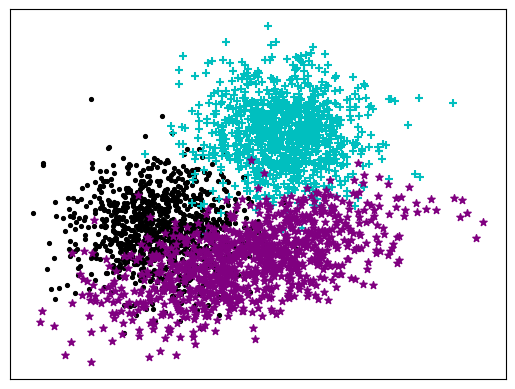

In [8]:
seed0 = 1
seed1 = 2
seed2 = 3
n0 = 1000
n1 = 1000
n2 = 1000


## Dataset multiclass 1
mu0 = [0, 0]
sigma0 = [[1, 0], [0, 1]]
mu1 = [3, 3]
sigma1 = [[1, 0], [0, 1]]
mu2 = [2, -1]
sigma2 = [[3, 1], [1, 1]]

X, y = normal_generator3(mu0, sigma0, n0, mu1, sigma1, n1, mu2, sigma2, n2, seed0, seed1, seed2)


In [9]:
sigma = 5
delta = 0.5
seed = 0
k_min = 0
host_instance_by_layer_df_ewkm, data_clusters_ewkm, results_ewkm, results_per_class_ewkm, probs_per_layer_ewkm, k_auto_ewkm, dict_f_w = hostility_measure_multiclass_ewkm(sigma, X, y, k_min, seed=0)


In [10]:
dict_f_w.keys()

dict_keys(['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4'])

In [11]:
dict_f_w['cluster_4']

array([[4.99975001e-05, 9.99950002e-01],
       [9.99950002e-01, 4.99975001e-05],
       [9.99950002e-01, 4.99975001e-05],
       [9.99950002e-01, 4.99975062e-05]])

Vamos a comparar los resultados con la función con k-means

In [12]:
sigma = 5
delta = 0.5
seed = 0
k_min = 0
host_instance_by_layer_df, data_clusters, results, results_per_class, probs_per_layer, k_auto = hostility_measure_multiclass(sigma, X, y, k_min, seed=0)

In [13]:
results

,Host_0,Host_1,Host_2,Dataset_Host
600,0.122,0.031,0.144,0.099000
120,0.129,0.030,0.132,0.097000
24,0.127,0.028,0.150,0.101667
4,0.129,0.035,0.145,0.103000


In [14]:
results_ewkm

,Host_0,Host_1,Host_2,Dataset_Host
600,0.149,0.043,0.141,0.111000
120,0.139,0.037,0.125,0.100333
24,0.131,0.040,0.131,0.100667
4,0.116,0.041,0.162,0.106333


In [15]:
results_per_class

{600:        0      1      2  Total
 0      0   0.01  0.112  0.122
 1  0.016      0  0.017  0.031
 2  0.127  0.018      0  0.144,
 120:        0      1      2  Total
 0      0  0.011  0.119  0.129
 1  0.017      0  0.015   0.03
 2  0.115  0.017      0  0.132,
 24:        0      1      2  Total
 0      0  0.015  0.113  0.127
 1  0.013      0  0.016  0.028
 2  0.127  0.029      0   0.15,
 4:        0      1      2  Total
 0      0  0.012   0.12  0.129
 1  0.017      0  0.019  0.035
 2  0.125   0.03      0  0.145}

In [16]:
results_per_class_ewkm

{600:        0      1      2  Total
 0      0  0.014  0.136  0.149
 1  0.015      0  0.029  0.043
 2  0.122   0.02      0  0.141,
 120:        0      1      2  Total
 0      0  0.014  0.126  0.139
 1  0.014      0  0.024  0.037
 2  0.111  0.015      0  0.125,
 24:        0      1      2  Total
 0      0  0.021   0.12  0.131
 1  0.017      0  0.031   0.04
 2  0.117  0.015      0  0.131,
 4:        0      1      2  Total
 0      0  0.024  0.105  0.116
 1  0.018      0  0.034  0.041
 2  0.148  0.015      0  0.162}

In [17]:
print('k_auto:',k_auto)
print('k_auto_ewkm:',k_auto_ewkm)

k_auto: 4
k_auto_ewkm: 4


Encontramos algunas diferencias numéricas entre ambos métodos pero van totalmente en línea

### Análisis de los pesos de las variables

In [18]:

def feature_weight_Host(dict_f_w):

    layer = 0
    for l in dict_f_w.keys():
        layer+=1
        df_layer = pd.DataFrame(dict_f_w[l])
        df_layer.boxplot(return_type='axes',meanline=True, showmeans=True);
        title_boxplot = 'Layer ' +str(layer)
        plt.title(title_boxplot)
        plt.show()
        print('Feature weights:')
        print(df_layer)
        print('Average feature weight:')
        print(df_layer.mean(axis=0))

    return

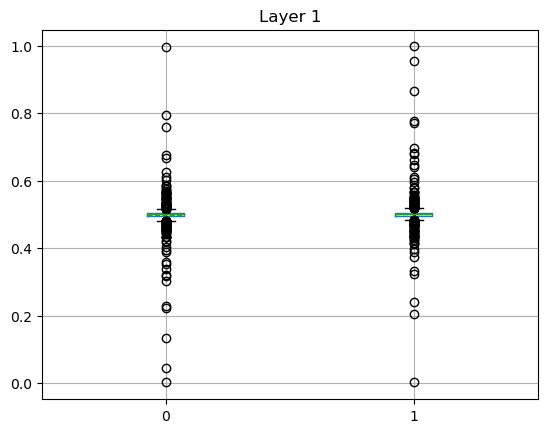

Feature weights:
            0         1
0    0.502209  0.497791
1    0.498576  0.501424
2    0.419265  0.580735
3    0.495781  0.504219
4    0.502043  0.497957
..        ...       ...
595  0.490103  0.509897
596  0.464930  0.535070
597  0.484002  0.515998
598  0.494738  0.505262
599  0.500000  0.500000

[600 rows x 2 columns]
Average feature weight:
0    0.497573
1    0.502427
dtype: float64


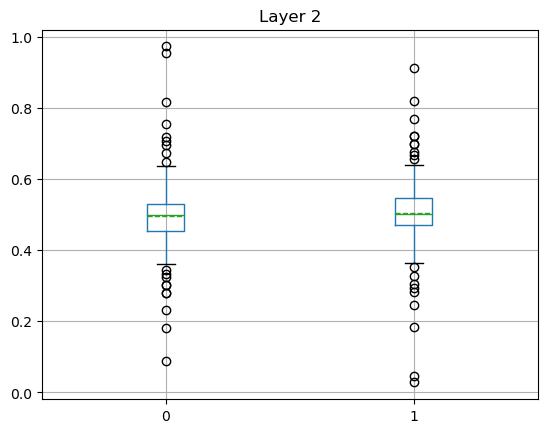

Feature weights:
            0         1
0    0.447270  0.552730
1    0.496819  0.503181
2    0.500000  0.500000
3    0.301247  0.698753
4    0.815574  0.184426
..        ...       ...
115  0.533063  0.466937
116  0.363172  0.636828
117  0.500000  0.500000
118  0.482076  0.517924
119  0.541068  0.458932

[120 rows x 2 columns]
Average feature weight:
0    0.496252
1    0.503748
dtype: float64


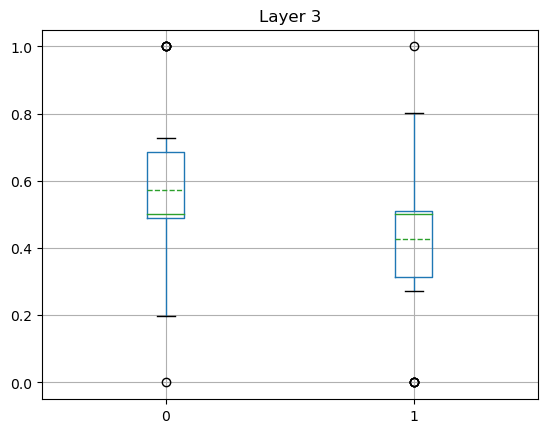

Feature weights:
           0         1
0   0.197135  0.802865
1   0.500000  0.500000
2   0.500000  0.500000
3   0.377677  0.622323
4   0.999950  0.000050
5   0.500000  0.500000
6   0.500000  0.500000
7   0.999950  0.000050
8   0.492171  0.507829
9   0.576652  0.423348
10  0.517731  0.482269
11  0.671158  0.328842
12  0.728421  0.271579
13  0.344104  0.655896
14  0.999950  0.000050
15  0.500000  0.500000
16  0.500000  0.500000
17  0.568928  0.431072
18  0.999950  0.000050
19  0.999950  0.000050
20  0.257972  0.742028
21  0.567395  0.432605
22  0.000050  0.999950
23  0.483212  0.516788
Average feature weight:
0    0.574265
1    0.425735
dtype: float64


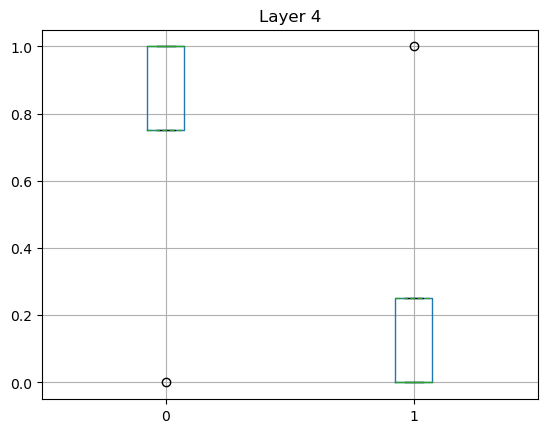

Feature weights:
         0        1
0  0.00005  0.99995
1  0.99995  0.00005
2  0.99995  0.00005
3  0.99995  0.00005
Average feature weight:
0    0.749975
1    0.250025
dtype: float64


In [19]:
feature_weight_Host(dict_f_w)

En este caso, ambas variables son igual de importantes a la hora de formar los clusters.

#### Variable redundante

Creamos ahora variables redudantes para ver si salen con menor peso. En particular, creamos una variable que sea una pequeña variación de otra. Por ejemplo, 0.2*x1.

In [20]:
var_red = 0.3*X[:,1]
X_df = pd.DataFrame(X,columns=['a','b'])
X_df['c'] = var_red
X_redundant = X_df.to_numpy()

host_instance_by_layer_df, data_clusters, results, results_per_class, probs_per_layer, k_auto, dict_f_w = hostility_measure_multiclass_ewkm(sigma, X_redundant, y, k_min, seed=0)



In [21]:
var_red = 0.3*X[:,1]
X_df = pd.DataFrame(X,columns=['a','b'])
X_df['c'] = var_red
X_redundant = X_df.to_numpy()

In [22]:
host_instance_by_layer_df, data_clusters, results, results_per_class, probs_per_layer, k_auto, dict_f_w = hostility_measure_multiclass_ewkm(sigma, X_redundant, y, k_min, seed=0)


In [23]:
dict_f_w

{'cluster_1': array([[0.29327912, 0.3381966 , 0.36852428],
        [0.33324394, 0.33323223, 0.33352383],
        [0.32523135, 0.33376003, 0.34100863],
        ...,
        [0.2878781 , 0.34953196, 0.36258994],
        [0.31257458, 0.26828281, 0.41914261],
        [0.33409108, 0.33200175, 0.33390717]]),
 'cluster_2': array([[0.29560014, 0.32079739, 0.38360248],
        [0.10370249, 0.23289513, 0.66340238],
        [0.33333333, 0.33333333, 0.33333333],
        [0.26472145, 0.35085391, 0.38442464],
        [0.3376153 , 0.3213637 , 0.341021  ],
        [0.21160143, 0.27406245, 0.51433612],
        [0.39598396, 0.14740299, 0.45661305],
        [0.35100657, 0.27529714, 0.37369629],
        [0.30954492, 0.32935912, 0.36109597],
        [0.3503601 , 0.26011176, 0.38952814],
        [0.30906534, 0.31853537, 0.37239929],
        [0.32424913, 0.32938207, 0.3463688 ],
        [0.06492943, 0.3226394 , 0.61243117],
        [0.27258446, 0.32533404, 0.4020815 ],
        [0.32554874, 0.33079776, 0.3436

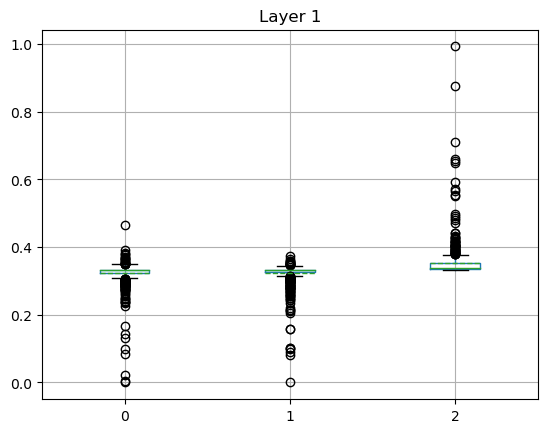

Feature weights:
            0         1         2
0    0.293279  0.338197  0.368524
1    0.333244  0.333232  0.333524
2    0.325231  0.333760  0.341009
3    0.334394  0.331475  0.334130
4    0.335820  0.326512  0.337668
..        ...       ...       ...
595  0.369343  0.215610  0.415047
596  0.332273  0.332182  0.335545
597  0.287878  0.349532  0.362590
598  0.312575  0.268283  0.419143
599  0.334091  0.332002  0.333907

[600 rows x 3 columns]
Average feature weight:
0    0.323063
1    0.322917
2    0.354020
dtype: float64


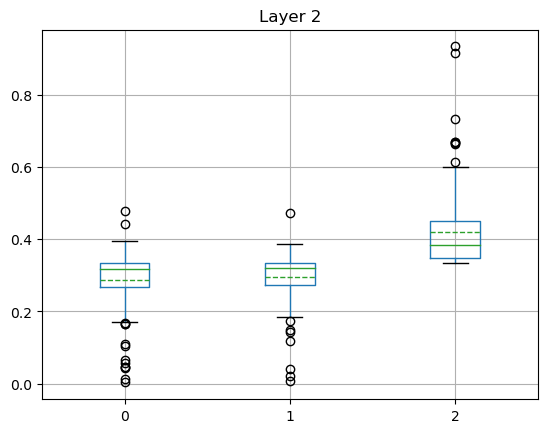

Feature weights:
            0         1         2
0    0.295600  0.320797  0.383602
1    0.103702  0.232895  0.663402
2    0.333333  0.333333  0.333333
3    0.264721  0.350854  0.384425
4    0.337615  0.321364  0.341021
..        ...       ...       ...
115  0.300167  0.341193  0.358640
116  0.299375  0.342766  0.357859
117  0.320891  0.296926  0.382183
118  0.390932  0.220715  0.388353
119  0.304519  0.226070  0.469411

[120 rows x 3 columns]
Average feature weight:
0    0.286736
1    0.294191
2    0.419073
dtype: float64


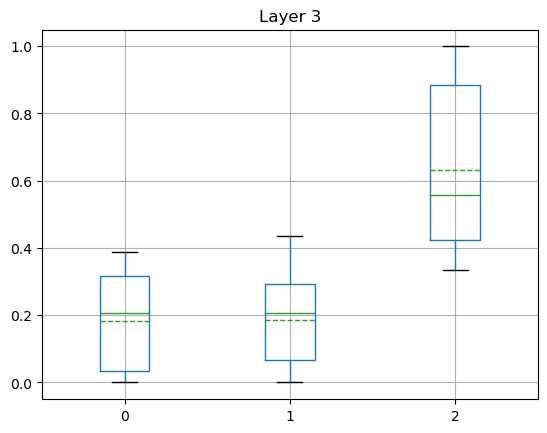

Feature weights:
           0         1         2
0   0.276747  0.307659  0.415594
1   0.382312  0.193201  0.424486
2   0.129258  0.151744  0.718998
3   0.195345  0.077757  0.726898
4   0.289223  0.258618  0.452160
5   0.310376  0.296036  0.393588
6   0.356535  0.292702  0.350763
7   0.039327  0.010776  0.949897
8   0.000033  0.128518  0.871449
9   0.333333  0.333333  0.333333
10  0.000703  0.000049  0.999248
11  0.388911  0.104775  0.506315
12  0.225268  0.225149  0.549584
13  0.215972  0.218223  0.565805
14  0.001169  0.036611  0.962219
15  0.333333  0.333333  0.333333
16  0.108485  0.435064  0.456451
17  0.333333  0.333333  0.333333
18  0.017296  0.271178  0.711526
19  0.043618  0.027393  0.928990
20  0.285884  0.230834  0.483282
21  0.081054  0.161232  0.757714
22  0.000981  0.018272  0.980746
23  0.010790  0.011481  0.977729
Average feature weight:
0    0.181637
1    0.185720
2    0.632643
dtype: float64


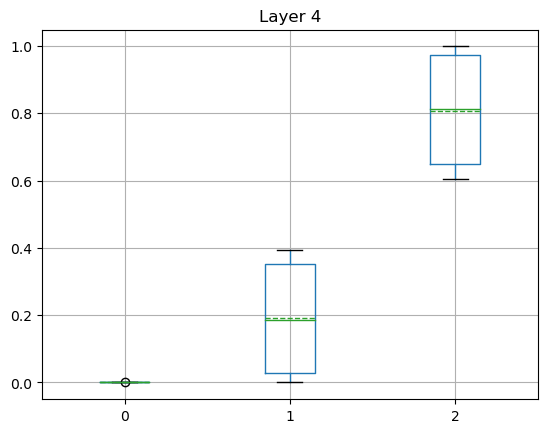

Feature weights:
          0         1         2
0  0.001656  0.000047  0.998296
1  0.000033  0.036727  0.963240
2  0.000033  0.337379  0.662588
3  0.000033  0.394325  0.605641
Average feature weight:
0    0.000439
1    0.192120
2    0.807441
dtype: float64


In [24]:
feature_weight_Host(dict_f_w)

Estos resultados me despistan

#### Probamos con unos datos reales

In [38]:
path_csv = os.chdir(root_path+'/datasets')
df = pd.read_csv('bupa.csv')
X = df.iloc[:,:-1].to_numpy() # all variables except y
X = preprocessing.scale(X)
y = df[df.columns[-1]].to_numpy()

In [39]:
df.head()

,Mcv,Alkphos,Sgpt,Sgot,Gammagt,Drinks,y
0,85,92,45,27,31,0.0,0
1,85,64,59,32,23,0.0,1
2,86,54,33,16,54,0.0,1
3,91,78,34,24,36,0.0,1
4,98,55,13,17,17,0.0,1


In [40]:
sigma = 5
delta = 0.5
seed = 0
k_min = 0
host_instance_by_layer_df_ewkm, data_clusters_ewkm, results_ewkm, results_per_class_ewkm, probs_per_layer_ewkm, k_auto_ewkm, dict_f_w = hostility_measure_multiclass_ewkm(sigma, X, y, k_min, seed=0)

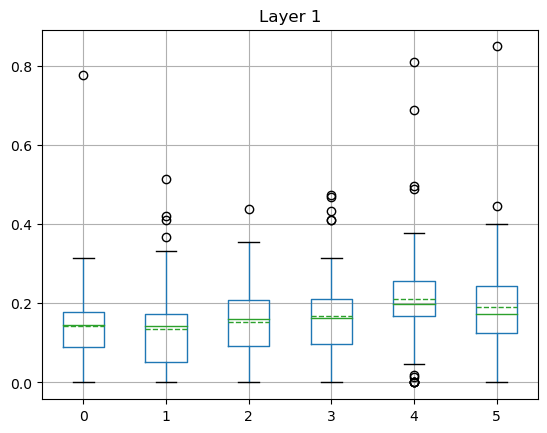

Feature weights:
           0         1         2         3         4         5
0   0.264898  0.179503  0.221491  0.136038  0.012894  0.185176
1   0.176358  0.143836  0.037854  0.195017  0.213875  0.233061
2   0.105782  0.078403  0.179369  0.200534  0.176596  0.259316
3   0.107080  0.079699  0.202996  0.209134  0.001084  0.400008
4   0.099507  0.060827  0.105103  0.149569  0.308509  0.276484
..       ...       ...       ...       ...       ...       ...
64  0.161926  0.155801  0.135718  0.154837  0.197807  0.193910
65  0.001370  0.131100  0.191903  0.094122  0.280491  0.301013
66  0.213334  0.053070  0.163173  0.157136  0.193854  0.219432
67  0.139902  0.069144  0.052939  0.410445  0.018829  0.308741
68  0.174239  0.160546  0.137096  0.162152  0.173138  0.192829

[69 rows x 6 columns]
Average feature weight:
0    0.143251
1    0.136141
2    0.152274
3    0.168751
4    0.210119
5    0.189464
dtype: float64


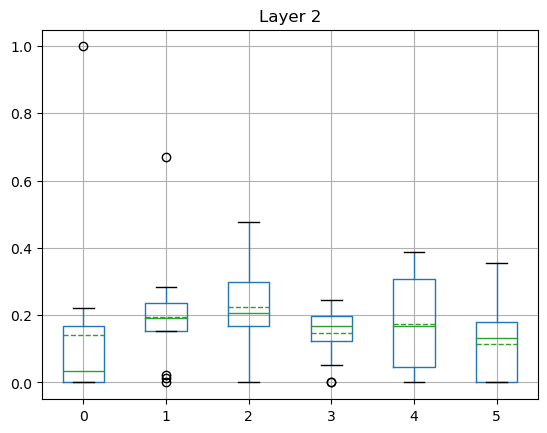

Feature weights:
           0         1         2         3         4         5
0   0.000085  0.669743  0.168189  0.161949  0.000017  0.000017
1   0.001492  0.153957  0.206491  0.194787  0.262968  0.180305
2   0.998175  0.000017  0.000017  0.000017  0.000017  0.001758
3   0.035393  0.235768  0.160309  0.196290  0.119915  0.252326
4   0.043535  0.012084  0.367175  0.244863  0.317487  0.014856
5   0.000017  0.191359  0.297560  0.122883  0.388165  0.000017
6   0.000017  0.284571  0.477048  0.237303  0.001044  0.000017
7   0.004529  0.240292  0.206942  0.050475  0.306310  0.191452
8   0.166667  0.166667  0.166667  0.166667  0.166667  0.166667
9   0.200972  0.198150  0.114006  0.203535  0.149950  0.133387
10  0.166667  0.166667  0.166667  0.166667  0.166667  0.166667
11  0.000017  0.023364  0.278664  0.000057  0.343893  0.354005
12  0.220276  0.202998  0.323494  0.169372  0.044684  0.039177
Average feature weight:
0    0.141372
1    0.195818
2    0.225633
3    0.147297
4    0.174445
5    0.

In [41]:
feature_weight_Host(dict_f_w)

In [33]:
X

array([[-1.16160129,  1.20792326,  0.74903488,  0.23448218, -0.18582878,
        -1.03662717],
       [-1.16160129, -0.32037257,  1.46757281,  0.73199972, -0.38992247,
        -1.03662717],
       [-0.93645946, -0.86619251,  0.13314523, -0.86005641,  0.40094058,
        -1.03662717],
       ...,
       [-1.16160129, -0.9753565 , -0.43142029, -0.16353185, -0.10929365,
         0.16349489],
       [ 1.08981694,  1.26250525, -0.48274443,  0.23448218,  0.2223586 ,
         0.76355592],
       [ 0.18924965,  1.26250525,  0.2357935 ,  0.93100674, -0.03275852,
         1.96367798]])